In [1]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
rating_data = pd.read_csv('./movie_data/movie_lens/ratings.csv')
movie_data = pd.read_csv('./movie_data/movie_lens/movies.csv')

In [3]:
rating_data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
print(movie_data.shape)

(9125, 3)


In [6]:
print(rating_data.shape)

(100004, 4)


# 전처리

In [7]:
rating_data.drop('timestamp', axis= 1, inplace=True)
rating_data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [8]:
movie_data.drop('genres', axis=1, inplace=True)
movie_data.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [9]:
user_movie_data = pd.merge(rating_data, movie_data, on='movieId')
user_movie_data.head()

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,7,31,3.0,Dangerous Minds (1995)
2,31,31,4.0,Dangerous Minds (1995)
3,32,31,4.0,Dangerous Minds (1995)
4,36,31,3.0,Dangerous Minds (1995)


In [10]:
user_movie_rating = user_movie_data.pivot_table('rating', index = 'userId', columns = 'title').fillna(0)

In [11]:
user_movie_rating.shape

(671, 9064)

In [12]:
user_movie_rating.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# 사용자 - 영화 기준 데이터를 영화-사용자 기준으로 만들어 특정 '영화'와 비슷한 영화를 추천하는 로직 구현
movie_user_rating = user_movie_rating.values.T
movie_user_rating.shape

(9064, 671)

In [14]:
type(movie_user_rating)

numpy.ndarray

여기서 이제 SVD를 사용합니다.   

**SVD(Singular Value Decomposion), 특이값 분해**란 m x n 크기의 데이터 행렬 A를 아래와 같이 분해하는 것을 말합니다.

![15](https://user-images.githubusercontent.com/24634054/73115129-93138c00-3f65-11ea-9a10-80abc59a8494.JPG)


출처 : https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/04/06/pcasvdlsa/

행렬 U와 V에 속한 열벡터는 특이벡터(singular vector)로 불리고, 이 특이벡터들은 서로 직교하는 성질을 가지고 있습니다.
또한, 가운데 시그마 기호로 보이는 것은 이것도 행렬인데요. 이 행렬은 대각행렬(diagonal matrix) 성질을 가지고 있습니다. 그래서 대각 성분이 행렬 A의 특이값이고 나머지 성분이 0입니다.


그리고 사이킷런에서 제공해주는 truncated SVD는 이러한 SVD의 변형입니다.
**truncated SVD**는 시그마 행렬의 대각원소(특이값) 가운데 상위 n개만 골라낸 것입니다. 이렇게 하면 기존 행렬 A의 성질을 100% 원복할 수는 없지만, (그 만큼 데이터 정보를 압축) 행렬 A와 거의 근사한 값이 나오게 됩니다.



여기서는 scikit learn의 TruncatedSVD를 사용해봅니다.

In [15]:
SVD = TruncatedSVD(n_components = 12)
matrix = SVD.fit_transform(movie_user_rating)
matrix.shape

(9064, 12)

In [16]:
matrix[0]

array([ 0.01227491,  0.00250776,  0.01554784, -0.03396915, -0.01446095,
        0.00358671, -0.00208487,  0.04491273, -0.01663778, -0.02048333,
        0.00973526, -0.00889381])

In [17]:
corr = np.corrcoef(matrix)
corr.shape

(9064, 9064)

In [18]:
corr2 = corr[:200,:200]
corr2.shape

(200, 200)

<AxesSubplot:>

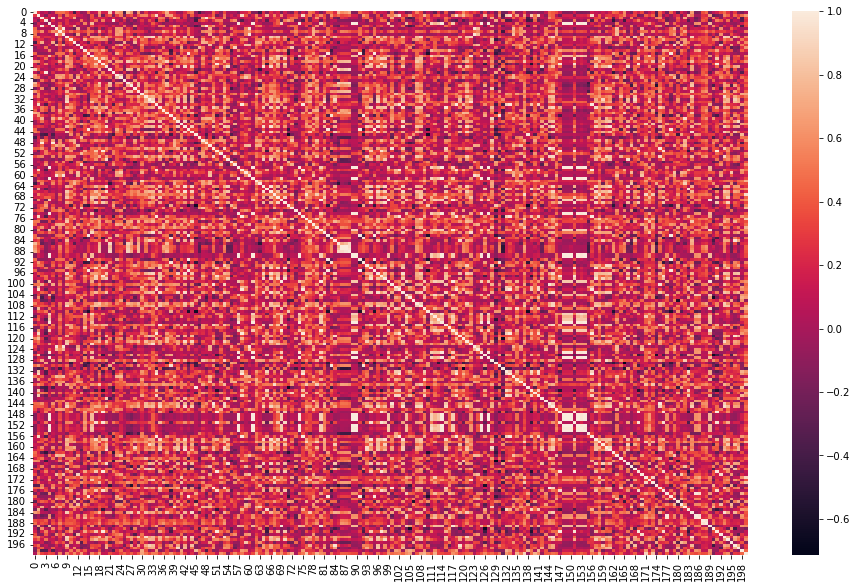

In [19]:
plt.figure(figsize=(16,10))
sns.heatmap(corr2)

In [20]:
movie_title = user_movie_rating.columns
movie_title_list = list(movie_title)
coffey_hands = movie_title_list.index("Guardians of the Galaxy (2014)")

In [21]:
corr_coffey_hands = corr[coffey_hands]
list(movie_title[(corr_coffey_hands >= 0.9)])[:50]

['10,000 BC (2008)',
 '2 Guns (2013)',
 '2012 (2009)',
 '300: Rise of an Empire (2014)',
 'Abduction (2011)',
 'Adjustment Bureau, The (2011)',
 'Adventures of Tintin, The (2011)',
 'Alice in Wonderland (2010)',
 'Amazing Spider-Man, The (2012)',
 'Angels & Demons (2009)',
 'Ant-Man (2015)',
 'Avatar (2009)',
 'Avengers, The (2012)',
 'Avengers: Age of Ultron (2015)',
 'Batman: The Dark Knight Returns, Part 1 (2012)',
 'Batman: The Dark Knight Returns, Part 2 (2013)',
 'Battle: Los Angeles (2011)',
 'Bee Movie (2007)',
 'Beowulf (2007)',
 'Big Hero 6 (2014)',
 'Bolt (2008)',
 'Brave (2012)',
 'Captain America: Civil War (2016)',
 'Captain America: The First Avenger (2011)',
 'Captain America: The Winter Soldier (2014)',
 'Chronicle (2012)',
 'Click (2006)',
 'Cloverfield (2008)',
 'Cop Out (2010)',
 'Crank: High Voltage (2009)',
 'Dark Knight Rises, The (2012)',
 'Diary of a Wimpy Kid (2010)',
 'District 9 (2009)',
 'Dredd (2012)',
 'Drillbit Taylor (2008)',
 'Déjà Vu (Deja Vu) (2006)'

In [22]:
df_ratings = pd.read_csv('./movie_data/movie_lens/ratings.csv')
df_movies = pd.read_csv('./movie_data/movie_lens/movies.csv')

In [23]:
df_user_movie_ratings = df_ratings.pivot(
    index = 'userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [24]:
df_user_movie_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


앞서 했던 것과 동일하게 사용자-영화 pivot table 제작

    1. pivot table을 matrix로 변환
    2. np.mean(axis = 1)을 통해 각 사용자들이 매기는 평점 평균 계산
    3. 1에서 구한 값과 2에서 구한 값을 빼서 사용자-평균 데이터 값을 변경

In [25]:
# matrix는 pivot_table 값ㅇ르 numpy matrix로 만든 것
matrix = df_user_movie_ratings.values

# user_ratings_mean은 사용자의 평점 평균
user_ratings_mean = np.mean(matrix, axis=1)

# R_user_mean : 사용자-영화에 대한 사용자 평균 평점을 뺀 것
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

In [26]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [27]:
matrix.shape

(671, 9066)

In [28]:
user_ratings_mean.shape

(671,)

In [29]:
matrix_user_mean.shape

(671, 9066)

In [30]:
pd.DataFrame(matrix_user_mean, columns = df_user_movie_ratings.columns).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,...,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625
1,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,3.970770,...,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230
2,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,...,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075
3,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,3.902162,...,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838
4,-0.043128,-0.043128,3.956872,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,...,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128


여기까지 진행하면 초기 만들었던 user-movie pivot talbe 값이 matrix_user_mean 변경

즉, 아래와 같이 변경

    1. 사용자 671명이 9066개의 영화에 대해 평점을 매긴 값이 존재
    2. 사용자 671명의 각각 평균 평점을 구해서
    3. 사용자 671며의 9066개의 영화에 대한 평점을 조금 변경 1에서 구한 값 - 2에서 구한값

In [31]:
#spicy에서 제공해주는 svd.
# U 행렬, sigma 행렬, V 전치 행렬을 반환

U, sigma, Vt = svds(matrix_user_mean, k = 12)

In [32]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(671, 12)
(12,)
(12, 9066)


현재 이 Sigma 행렬은 0이 아닌 값만 1차원 행렬로 표현된 상태
즉, 0이 포함된 대칭행렬로 변환할 때는 numpy의 diag를 이용해야함

In [33]:
sigma = np.diag(sigma)

In [34]:
sigma.shape

(12, 12)

In [35]:
sigma[0]

array([105.72437051,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [36]:
sigma[1]

array([  0.        , 110.15522471,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

대칭 행렬로 변환

1. 원본 user-movie 평점 행렬
2. 이를 user의 평균 점수를 빼서 matrix_user_mean 이라는 행렬로 만듬
3. 2번의 값을 SVD를 적용해 U, Sigma, Vt 행렬을 구했음
4. Sigma 행렬은 현재 0이 포함이 되지 않은 값으로만 구성되어 있음. 이를 대칭행렬로 변환


자! 이제 여기서 matrix_user_mean을 SVD를 적용해 분해를 한 상태입니다.  
이제, 다시 원본 행렬로 복구시켜야겠죠?

원본 행렬로 복구시키는 방법은 아래와 같습니다.

- U, Sigma, Vt의 내적을 수행 

즉, np.dot(np.dot(U, sigma), Vt)를 수행하면 됩니다. 

그리고 아까 사용자 평균을 빼주었으니 여기서는 더해줍니다. 
